# Independent Component Analysis vs. Factor Analysis

In [150]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.datasets import load_iris
from sklearn.decomposition import PCA, FactorAnalysis, FastICA
from sklearn.preprocessing import StandardScaler

In [151]:
iris = load_iris()
X = StandardScaler().fit_transform(iris.data)
feature_names = iris.feature_names

Text(0.5, 1.0, 'Iris feature correlation matrix')

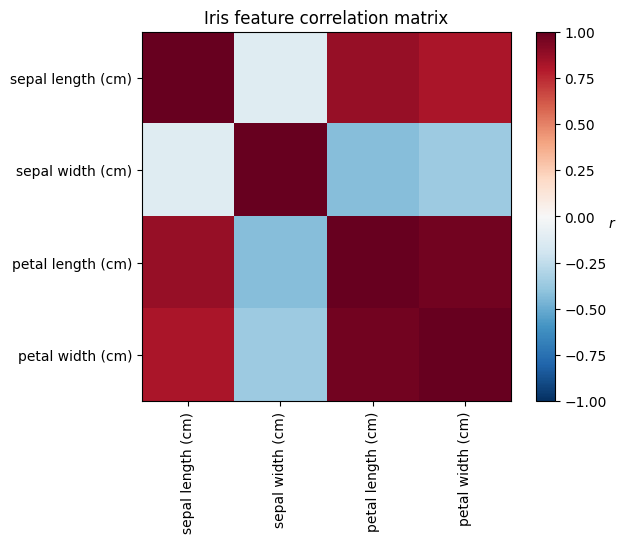

In [152]:
ax = plt.axes()
im = ax.imshow(np.corrcoef(X.T), cmap="RdBu_r", vmin=-1, vmax=1)

ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(list(feature_names), rotation=90)
ax.set_yticks([0, 1, 2, 3])
ax.set_yticklabels(list(feature_names))

plt.colorbar(im,).ax.set_ylabel("$r$", rotation=0)
ax.set_title("Iris feature correlation matrix")



 PCA :

[[ 0.52106591  0.37741762]
 [-0.26934744  0.92329566]
 [ 0.5804131   0.02449161]
 [ 0.56485654  0.06694199]]


 ICA :

[[ 0.3145811   0.38718349]
 [-0.13397726  0.96931051]
 [ 0.34027375  0.01729336]
 [ 0.33225723  0.06190482]]


 Unrotated FA :

[[ 0.88096009 -0.4472869 ]
 [-0.41691605 -0.55390036]
 [ 0.99918858  0.01915283]
 [ 0.96228895  0.05840206]]


 Varimax FA :

[[ 0.98633022 -0.05752333]
 [-0.16052385 -0.67443065]
 [ 0.90809432  0.41726413]
 [ 0.85857475  0.43847489]]


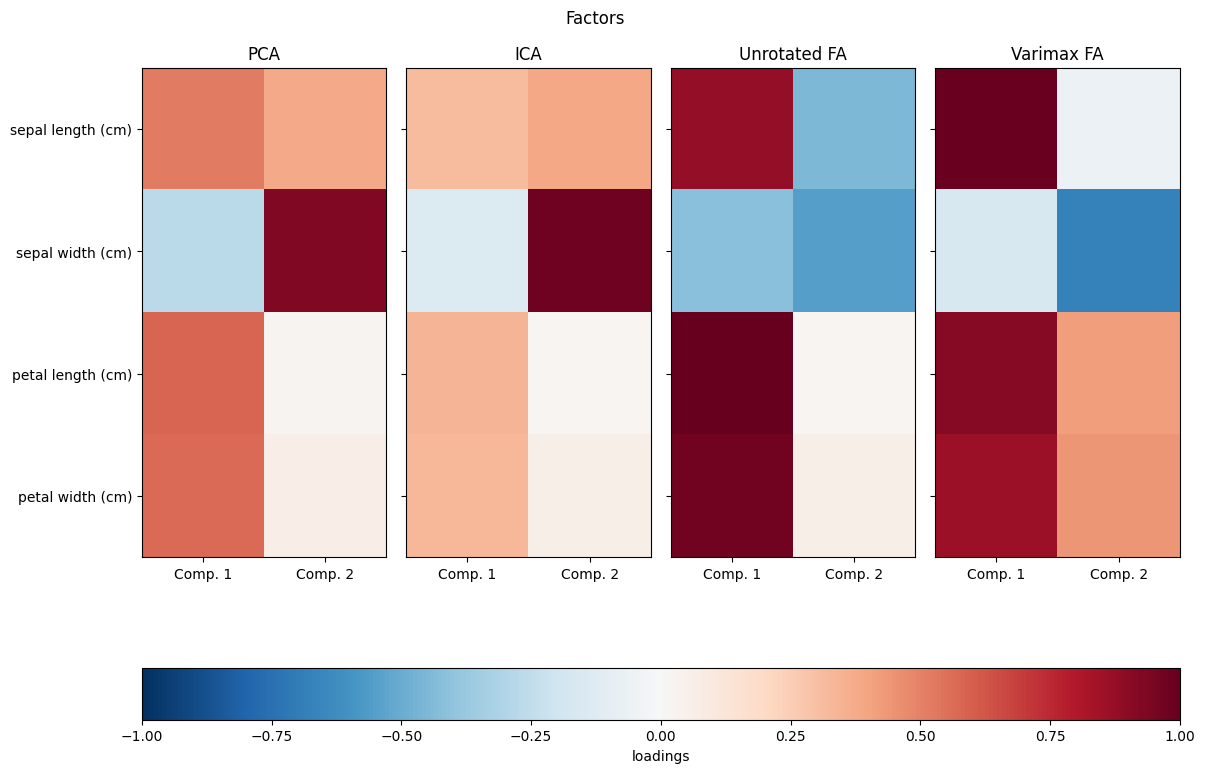

In [157]:
n_comps = 2
rng = 42

methods = [
    ("PCA", PCA(random_state=rng)),
    ("ICA", FastICA(random_state=rng, whiten="unit-variance")),
    ("Unrotated FA", FactorAnalysis(random_state=rng)),
    #("Quartimax FA", FactorAnalysis(rotation="quartimax", random_state=rng)),
    ("Varimax FA", FactorAnalysis(rotation="varimax", random_state=rng)),
]
fig, axes = plt.subplots(ncols=len(methods), figsize=(12, 8), sharey=True)
communalities = []

for ax, (method, fa) in zip(axes, methods):
    fa.set_params(n_components=n_comps)
    fa.fit(X)

    components = fa.components_.T
    print("\n\n %s :\n" % method)
    print(components)

    communalities.append(
        pd.Series(np.square(components).sum(axis=1), index=feature_names)
    )

    vmax = np.abs(components).max()
    im = ax.imshow(components, cmap="RdBu_r", vmax=1, vmin=-1)
    ax.set_yticks(np.arange(len(feature_names)))
    ax.set_yticklabels(feature_names)
    ax.set_title(str(method))
    ax.set_xticks([0, 1])
    ax.set_xticklabels(["Comp. 1", "Comp. 2"])
fig.suptitle("Factors")
plt.tight_layout()
cb = fig.colorbar(im, ax=axes, location="bottom", label="loadings")
plt.show()

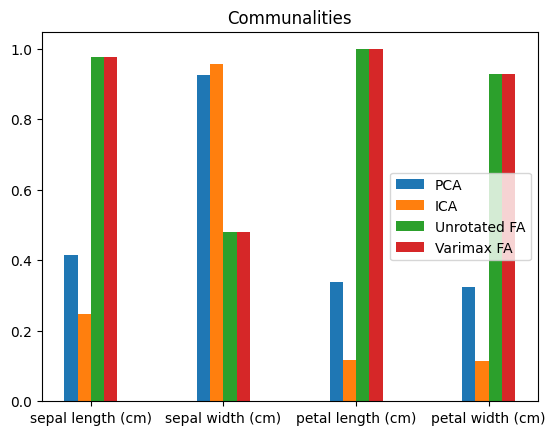

In [121]:
ax = plt.axes()
ax.set_xticks(np.arange(len(feature_names)))
ax.set_xticklabels(list(feature_names))
ax.set_title("Communalities")

for i, c in enumerate(communalities):
    r = np.arange(len(c))
    bw = .1
    r_off = r + (i-len(c)//2)*bw + .5*bw
    plt.bar(r_off, c, width=bw, label=f"{methods[i][0]}")

#plt.axes().set_xticks(np.arange(len(list(feature_names)) + .2))
#plt.axes().set_xticklabels(list(feature_names))
plt.legend(loc=7)
plt.show()

## Model selection with homo/heteroscedasticity

In [147]:
import numpy as np
from scipy import linalg

n_samples, n_features, rank = 500, 25, 5
sigma = 1.0
rng = np.random.RandomState(42)
U, _, _ = linalg.svd(rng.randn(n_features, n_features))
X = np.dot(rng.randn(n_samples, rank), U[:, :rank].T)

# Adding homoscedastic noise
X_homo = X + sigma * rng.randn(n_samples, n_features)

# Adding heteroscedastic noise
sigmas = sigma * rng.rand(n_features) + sigma / 2.0
X_hetero = X + rng.randn(n_samples, n_features) * sigmas

best n_components by PCA CV = 5
best n_components by FactorAnalysis CV = 5
best n_components by PCA MLE = 5


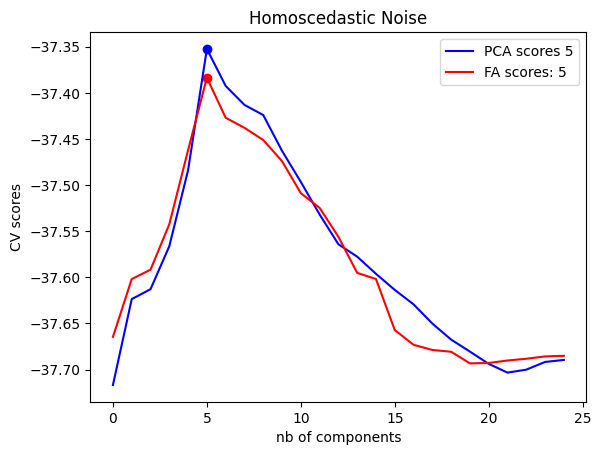

In [148]:
import matplotlib.pyplot as plt

from sklearn.covariance import LedoitWolf, ShrunkCovariance
from sklearn.decomposition import PCA, FactorAnalysis, FastICA
from sklearn.model_selection import GridSearchCV, cross_val_score

n_components = np.arange(0, n_features, 1)  # options for n_components


def compute_scores(X):
    pca = PCA(svd_solver="full")
    fa = FactorAnalysis()

    pca_scores, fa_scores = [], []
    for n in n_components:
        pca.n_components = n
        fa.n_components = n
        pca_scores.append(np.mean(cross_val_score(pca, X)))
        fa_scores.append(np.mean(cross_val_score(fa, X)))

    return pca_scores, fa_scores


def shrunk_cov_score(X):
    shrinkages = np.logspace(-2, 0, 30)
    cv = GridSearchCV(ShrunkCovariance(), {"shrinkage": shrinkages})
    return np.mean(cross_val_score(cv.fit(X).best_estimator_, X))


def lw_score(X):
    return np.mean(cross_val_score(LedoitWolf(), X))


for X, title in [(X_homo, "Homoscedastic Noise")]:
    pca_scores, fa_scores = compute_scores(X)
    n_components_pca = n_components[np.argmax(pca_scores)]
    n_components_fa = n_components[np.argmax(fa_scores)]

    pca = PCA(svd_solver="full", n_components="mle")
    pca.fit(X)
    n_components_pca_mle = pca.n_components_

    print("best n_components by PCA CV = %d" % n_components_pca)
    print("best n_components by FactorAnalysis CV = %d" % n_components_fa)
    print("best n_components by PCA MLE = %d" % n_components_pca_mle)

    plt.figure()
    plt.plot(n_components, pca_scores, "b", label=f"PCA scores {n_components_pca}")
    plt.plot(n_components, fa_scores, "r", label=f"FA scores: {n_components_fa}")
    plt.scatter(n_components_pca, np.max(pca_scores), color="b")
    plt.scatter(n_components_fa, np.max(fa_scores), color="r")

    plt.xlabel("nb of components")
    plt.ylabel("CV scores")
    plt.legend(loc=0)
    plt.title(title)

plt.show()

best n_components by PCA CV = 24
best n_components by FactorAnalysis CV = 5
best n_components by PCA MLE = 18


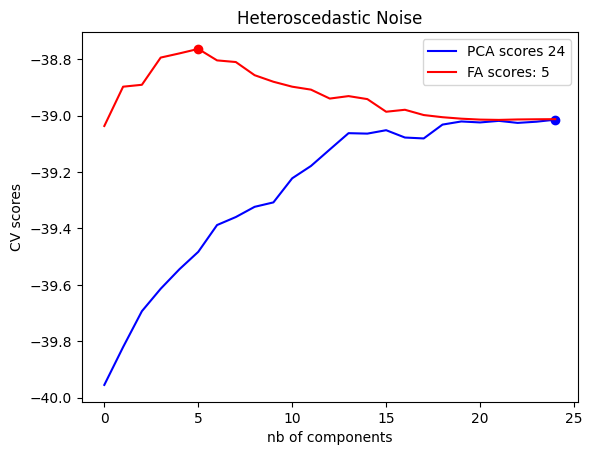

In [149]:
for X, title in [(X_hetero, "Heteroscedastic Noise")]:
    pca_scores, fa_scores = compute_scores(X)
    n_components_pca = n_components[np.argmax(pca_scores)]
    n_components_fa = n_components[np.argmax(fa_scores)]

    pca = PCA(svd_solver="full", n_components="mle")
    pca.fit(X)
    n_components_pca_mle = pca.n_components_

    print("best n_components by PCA CV = %d" % n_components_pca)
    print("best n_components by FactorAnalysis CV = %d" % n_components_fa)
    print("best n_components by PCA MLE = %d" % n_components_pca_mle)

    plt.figure()
    plt.plot(n_components, pca_scores, "b", label=f"PCA scores {n_components_pca}")
    plt.plot(n_components, fa_scores, "r", label=f"FA scores: {n_components_fa}")
    plt.scatter(n_components_pca, np.max(pca_scores), color="b")
    plt.scatter(n_components_fa, np.max(fa_scores), color="r")

    plt.xlabel("nb of components")
    plt.ylabel("CV scores")
    plt.legend(loc=0)
    plt.title(title)

plt.show()

## Signals with PCA, ICA and FA

In [104]:
import numpy as np
from scipy import signal

np.random.seed(0)
n_samples = 2000
time = np.linspace(0, 8, n_samples)

s1 = np.sin(2 * time)  # Signal 1 : sinusoidal signal
s2 = np.sign(np.sin(3 * time))  # Signal 2 : square signal
s3 = signal.sawtooth(2 * np.pi * time)  # Signal 3: saw tooth signal

S = np.c_[s1, s2, s3]
S += 0.2 * np.random.normal(size=S.shape)  # Add noise

S /= S.std(axis=0)  # Standardize data
# Mix data
A = np.array([[1, 1, 1], [0.5, 2, 1.0], [1.5, 1.0, 2.0]])  # Mixing matrix
X = np.dot(S, A.T)  # Generate observations

In [109]:
from sklearn.decomposition import PCA, FastICA, FactorAnalysis

# Compute ICA
ica = FastICA(n_components=3, whiten="arbitrary-variance")
S_ = ica.fit_transform(X)  # Reconstruct signals
A_ = ica.mixing_  # Get estimated mixing matrix

# We can `prove` that the ICA model applies by reverting the unmixing.
assert np.allclose(X, np.dot(S_, A_.T) + ica.mean_)

# For comparison, compute PCA
pca = PCA(n_components=3)
H = pca.fit_transform(X)  # Reconstruct signals based on orthogonal components

# Also, we compute FA
fa = FactorAnalysis(n_components=3, rotation="varimax")
H_fa = pca.fit_transform(X)

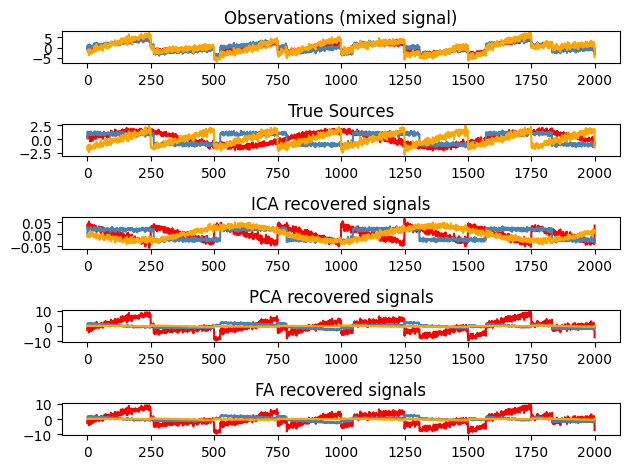

In [110]:
import matplotlib.pyplot as plt

plt.figure()

models = [X, S, S_, H, H_fa]
names = [
    "Observations (mixed signal)",
    "True Sources",
    "ICA recovered signals",
    "PCA recovered signals",
    "FA recovered signals",
]
colors = ["red", "steelblue", "orange"]

for ii, (model, name) in enumerate(zip(models, names), 1):
    plt.subplot(5, 1, ii)
    plt.title(name)
    for sig, color in zip(model.T, colors):
        plt.plot(sig, color=color)

plt.tight_layout()
plt.show()

## Decompose scatterplots

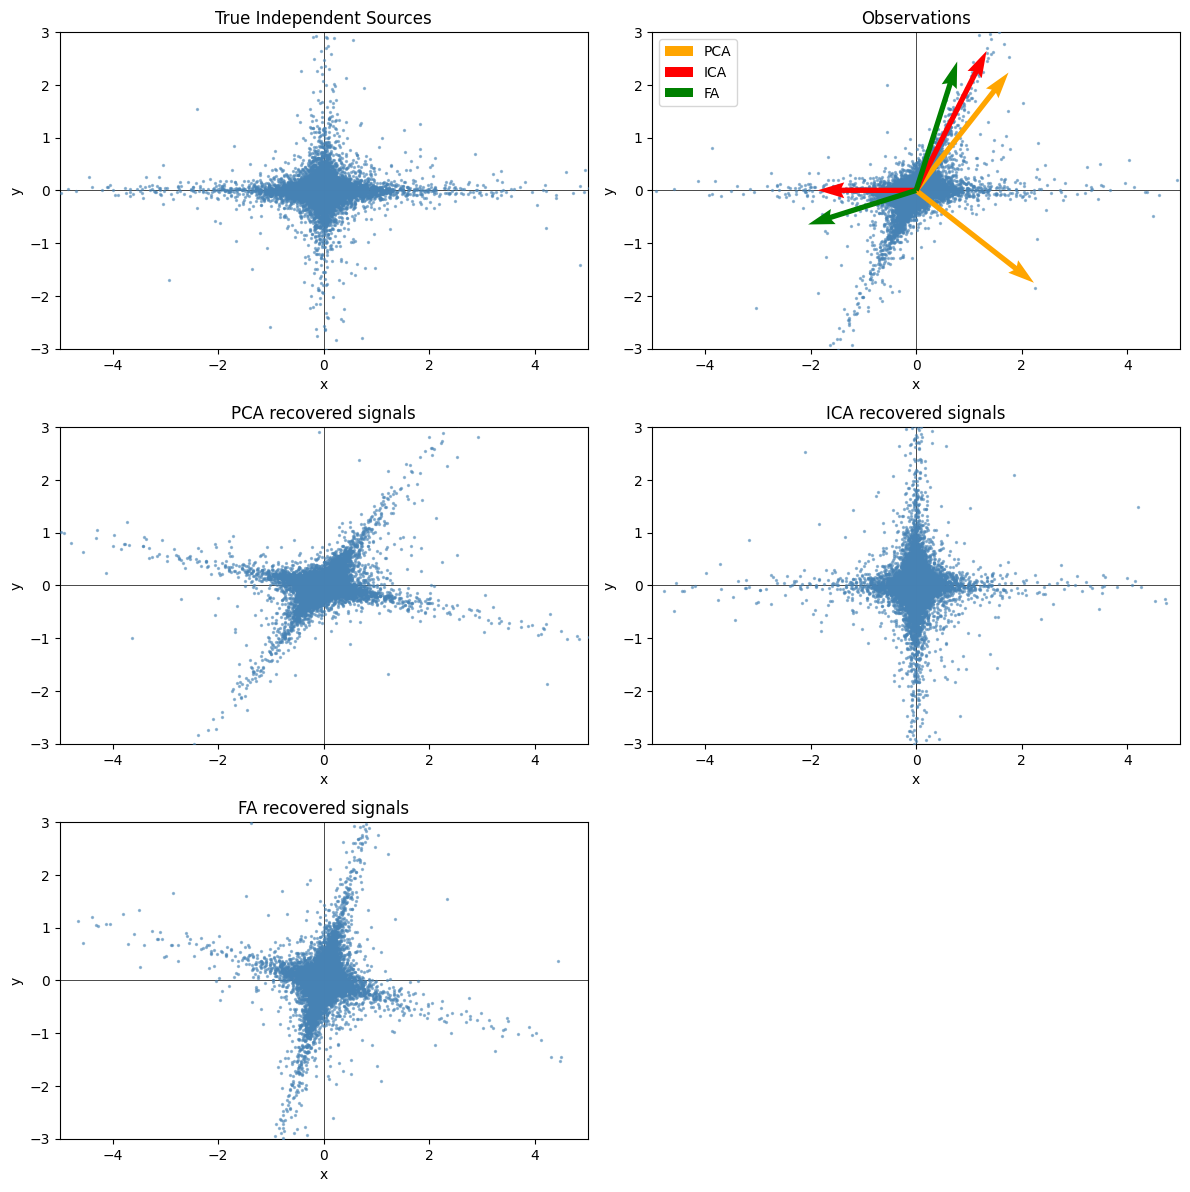

In [173]:
import numpy as np

from sklearn.decomposition import PCA, FastICA, FactorAnalysis

rng = np.random.RandomState(42)
S = rng.standard_t(1.5, size=(20000, 2))
S[:, 0] *= 2.0

# Mix data
A = np.array([[1, 1], [0, 2]])  # Mixing matrix

X = np.dot(S, A.T)  # Generate observations

pca = PCA()
S_pca_ = pca.fit(X).transform(X)

ica = FastICA(random_state=rng, whiten="arbitrary-variance")
S_ica_ = ica.fit(X).transform(X)  # Estimate the sources

fa = FactorAnalysis(rotation="varimax")
S_fa_ = fa.fit(X).transform(X)

import matplotlib.pyplot as plt


def plot_samples(S, axis_list=None):
    plt.scatter(
        S[:, 0], S[:, 1], s=2, marker="o", zorder=10, color="steelblue", alpha=0.5
    )
    if axis_list is not None:
        for axis, color, label in axis_list:
            x_axis, y_axis = axis / axis.std()
            plt.quiver(
                (0, 0),
                (0, 0),
                x_axis,
                y_axis,
                zorder=11,
                width=0.01,
                scale=6,
                color=color,
                label=label,
            )

    plt.hlines(0, -5, 5, color="black", linewidth=0.5)
    plt.vlines(0, -3, 3, color="black", linewidth=0.5)
    plt.xlim(-5, 5)
    plt.ylim(-3, 3)
    plt.gca().set_aspect("equal")
    plt.xlabel("x")
    plt.ylabel("y")


plt.figure(figsize=(12, 12))
plt.subplot(3, 2, 1)
plot_samples(S / S.std())
plt.title("True Independent Sources")

axis_list = [(pca.components_.T, "orange", "PCA"), (ica.mixing_, "red", "ICA"), (fa.components_.T, "green", "FA")]
plt.subplot(3, 2, 2)
plot_samples(X / np.std(X), axis_list=axis_list)
legend = plt.legend(loc="upper left")
legend.set_zorder(100)

plt.title("Observations")

plt.subplot(3, 2, 3)
plot_samples(S_pca_ / np.std(S_pca_))
plt.title("PCA recovered signals")

plt.subplot(3, 2, 4)
plot_samples(S_ica_ / np.std(S_ica_))
plt.title("ICA recovered signals")

plt.subplot(3, 2, 5)
plot_samples(S_fa_ / np.std(S_fa_))
plt.title("FA recovered signals")

plt.subplots_adjust(0.09, 0.04, 0.94, 0.94, 0.26, 0.36)
plt.tight_layout()
plt.show()